# Optimization

# Visualize the optimization process

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn.parallel
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from autograd_lib import autograd_lib
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True) 
                                           
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [3]:
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader

In [4]:
def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def trainingFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('Started')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            prediction = model(images)

            images.requires_grad = True
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        for name, parameter in model.named_parameters():
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [7]:
def testingFunc(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf

In [9]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [10]:
max_epochs = 40
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count)+'\n')
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainingFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testingFunc(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt], ignore_index=True)
    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr

Time: 0

Started
Time: 1y of the network on the test images: 98.0% & Test Loss: 0.06464676409959794

Started
Time: 2y of the network on the test images: 97.91% & Test Loss: 0.06740313563495874

Started
Time: 3y of the network on the test images: 97.98% & Test Loss: 0.0654743505641818

Started
Time: 4y of the network on the test images: 98.07% & Test Loss: 0.0651358331553638

Started
Time: 5y of the network on the test images: 98.03% & Test Loss: 0.06299407808110118

Started
Time: 6y of the network on the test images: 97.91% & Test Loss: 0.06787399370223283

Started
Time: 7y of the network on the test images: 97.94% & Test Loss: 0.0665555157698691

Started


In [11]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])

print(all_df)
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = all_df
print(pd.DataFrame(t1))


              0             1             2             3             4    \
0    8.407485e-03  3.342532e-05 -1.456931e-05 -1.231878e-05  5.416778e-05   
1    8.579916e-04 -7.691950e-06  3.082596e-05  1.864994e-07  2.536470e-06   
2   -4.852979e-06 -6.665609e-07 -1.637773e-06  1.594748e-08 -1.883618e-08   
3   -8.169295e-07  3.363233e-08 -8.366516e-08  4.396322e-11  1.042210e-09   
4    4.876665e-08 -1.464084e-09 -2.386475e-09 -4.365259e-11 -2.059961e-10   
..            ...           ...           ...           ...           ...   
315 -8.077491e-40  1.150672e-38 -2.833112e-39  1.833296e-39  7.214854e-39   
316 -8.077491e-40  1.150672e-38 -2.833112e-39  1.833296e-39  7.214854e-39   
317 -8.077491e-40  1.150672e-38 -2.833112e-39  1.833296e-39  7.214854e-39   
318 -8.077491e-40  1.150672e-38 -2.833112e-39  1.833296e-39  7.214854e-39   
319 -8.077491e-40  1.150672e-38 -2.833112e-39  1.833296e-39  7.214854e-39   

              5             6             7             8             9    

In [12]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

            x         y  Epoch  Iteration        Acc      Loss
0   -5.014811 -5.165265      0          0  45.474434  1.297166
1   -6.186469 -6.326766      1          0  87.930283  0.397275
2   -6.932097 -7.073815      2          0  91.431844  0.294412
3   -7.555522 -7.698049      3          0  92.737206  0.249932
4   -8.097695 -8.234055      4          0  93.776543  0.215904
..        ...       ...    ...        ...        ...       ...
315  3.393221  4.100043     35          7  99.411642  0.027550
316  3.386786  4.093468     36          7  99.560817  0.026305
317  3.379657  4.083909     37          7  99.574197  0.024459
318  3.375612  4.075552     38          7  99.575013  0.023367
319  3.367381  4.065535     39          7  99.617196  0.022965

[320 rows x 6 columns]


,x,y,Epoch,Iteration,Acc,Loss
0,-6.932097,-7.073815,2,0,91.431844,0.294412
1,-8.577496,-8.707823,5,0,94.409239,0.190290
2,-9.648472,-9.786027,8,0,96.010152,0.138795
3,-10.322646,-10.474998,11,0,97.002113,0.106105
4,-10.763402,-10.926226,14,0,97.657159,0.084977
...,...,...,...,...,...,...
99,3.397334,4.104586,26,7,98.852071,0.044621
100,3.405189,4.113907,29,7,99.119902,0.037697
101,3.400297,4.111563,32,7,99.301663,0.031884
102,3.393221,4.100043,35,7,99.411642,0.027550


In [13]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

104

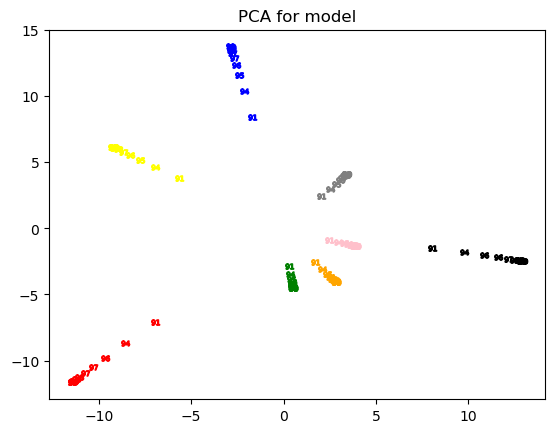

<Figure size 5000x2500 with 0 Axes>

In [14]:
cmap = ['red','blue','green','yellow','orange','pink','black','grey']

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model")
    
plt.figure(figsize=[10,5],dpi=500)


plt.show()

In [15]:
layer1_Df = all_df.iloc[:,0:7840]

t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [16]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df

,x,y,Epoch,Iteration,Acc,Loss
0,-0.148712,0.544244,0,0,45.474434,1.297166
1,-0.181425,0.765960,1,0,87.930283,0.397275
2,-0.193128,0.899943,2,0,91.431844,0.294412
3,-0.201463,1.003102,3,0,92.737206,0.249932
4,-0.221457,1.107591,4,0,93.776543,0.215904
...,...,...,...,...,...,...
315,-0.736483,-0.101522,35,7,99.411642,0.027550
316,-0.729971,-0.101033,36,7,99.560817,0.026305
317,-0.730933,-0.096304,37,7,99.574197,0.024459
318,-0.729148,-0.097505,38,7,99.575013,0.023367


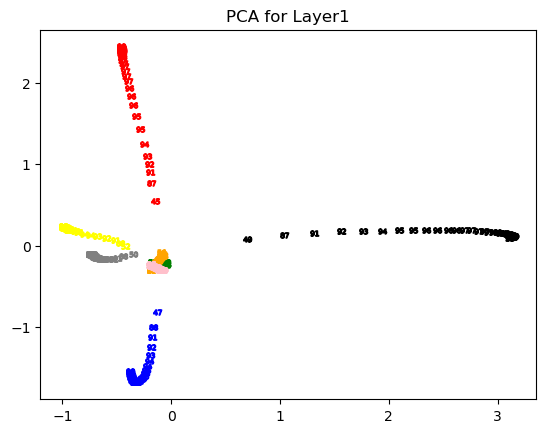

In [17]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))

for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1")


plt.show()   

# Observe gradient norm during training.

Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


/local_scratch/slurm.705790/ipykernel_2890762/3138566348.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


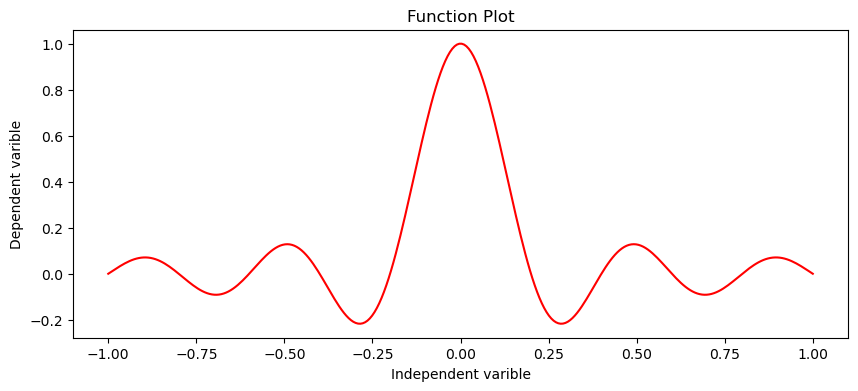

In [18]:
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1) 
y = (np.sin(5*np.pi*x))/(5*np.pi*x) 
print('Xshape:',x.shape,"\n Yshape:",y.shape)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

plt.figure(figsize=(10,4))
plt.plot(x, y, color = "red")
plt.title('Function Plot')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')

plt.show()

n_samples, n_features = x.shape

In [19]:
class M1(nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
torch.manual_seed(1)
m1 = M1()     
optimizer = torch.optim.Adam(m1.parameters(), lr=1e-2, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss() 

a=[]
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 1501


In [22]:
M1epoch_arr,M1loss_arr,M1prediction,M1grad_norm,M1gradArr = trainingFunction(m1,x,y)

epoch: 100, loss = 0.0432, grad_norm = 0.041747940230259496
epoch: 200, loss = 0.0069, grad_norm = 0.08243957030743936
epoch: 300, loss = 0.0029, grad_norm = 0.10079567330349176
epoch: 400, loss = 0.0020, grad_norm = 0.20784507951298142
epoch: 500, loss = 0.0018, grad_norm = 0.29080427839253065
epoch: 600, loss = 0.0013, grad_norm = 0.1445814371568513
epoch: 700, loss = 0.0013, grad_norm = 0.23564723913792426
Convergeance reached for loss: 0.0009919503


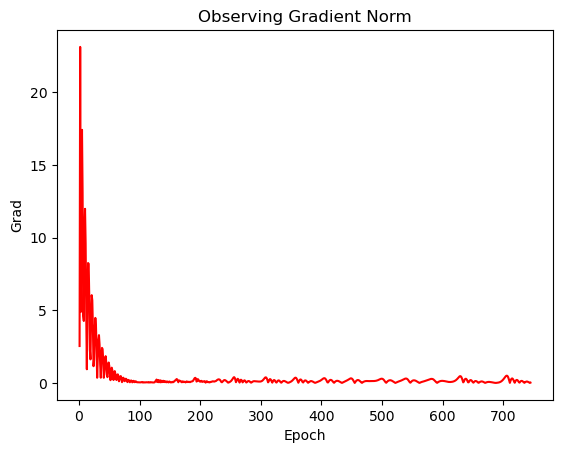

In [23]:
plt.plot(M1epoch_arr,M1gradArr,color="red")
plt.title('Observing Gradient Norm')
plt.xlabel("Epoch")
plt.ylabel("Grad")
plt.show()

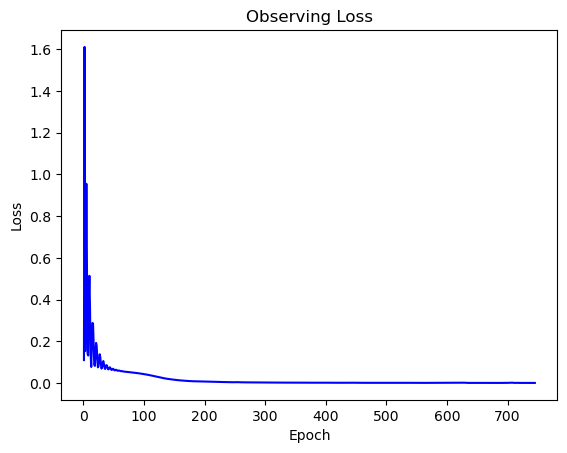

In [24]:
plt.plot(M1epoch_arr,M1loss_arr,color="blue")
plt.title('Observing Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

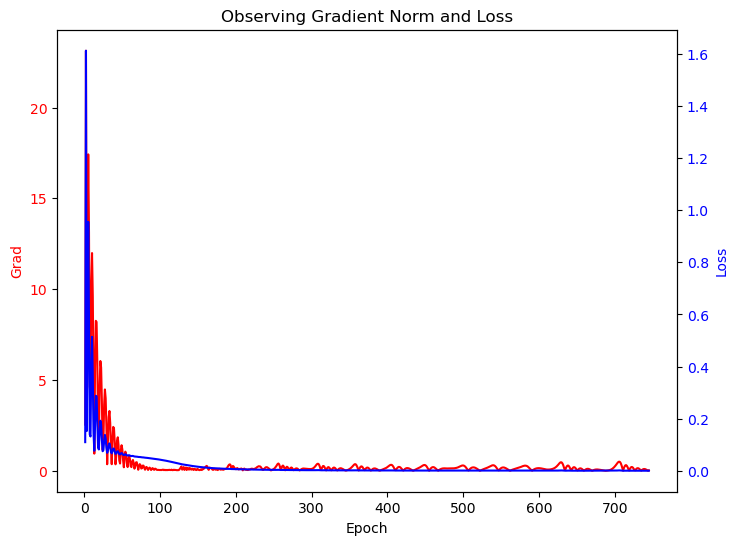

In [25]:
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Grad', color=color)
ax1.plot(M1epoch_arr, M1gradArr, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(M1epoch_arr, M1loss_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Observing Gradient Norm and Loss')
plt.show()

# What happens when gradient is almost zero

In [10]:
Y_func = lambda x: torch.sin(5 * np.pi * x) / (5 * np.pi * x)
num_of_rows = 300
X = torch.unsqueeze(torch.linspace(-1, 1, num_of_rows), dim=1)
Y = Y_func(X)

dataset = TensorDataset(X, Y)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [11]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        return self.regressor(x)

    def training_step(self, batch, loss_fn):
        inputs, targets = batch
        out = self(inputs)
        loss = loss_fn(out, targets)
        return loss

    def validation_step(self, batch, loss_fn):
        inputs, targets = batch
        out = self(inputs)
        loss = loss_fn(out, targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch+1}], val_loss: {result["val_loss"]:.4f}')



In [12]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads)
    return grad_mean

In [13]:

def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward(create_graph=True)

    hessian_list = []
    for param in model.parameters():
        if param.requires_grad and param.grad is not None:
            hessian = []
            for grad in param.grad.view(-1):
                hess_grad = torch.autograd.grad(grad, param, retain_graph=True)[0]
                hessian.append(hess_grad.view(-1))
            hessian = torch.stack(hessian)
            hessian_list.append(hessian)

    minimum_ratio = []
    for hess in hessian_list:
        size = hess.shape[0]
        h = hess.reshape(size, size)
        h_eig = torch.linalg.eigvalsh(h)
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio)
    return ratio_mean


In [14]:
def get_norm_minimal_ratio(model, criterion):
    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)
    return {"grad_norm": gradient_norm, "ratio": minimum_ratio}


In [15]:
def evaluate(model, loss_fn, val_loader):
    outputs = [model.validation_step(batch, loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)


In [16]:
def fit(epochs, lr, model, data_loader, criterion, opt_func):
    history = []
    grad_norm_per_epoch = {}
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()

        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model, criterion)
        optimizer.step()

        optimizer.zero_grad()
        result = evaluate(model, criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    for epoch in range(50):
        optimizer.zero_grad()
        grad_norm_result = get_norm_minimal_ratio(model, criterion)
        grad_norm_per_epoch[epochs + epoch] = grad_norm_result
        if grad_norm_result['grad_norm'] < 1e-4:
            break
        optimizer.step()
        
    return history, grad_norm_per_epoch, model


In [18]:
all_minimal_ratios = []
all_losses = []
for _ in range(100):
    model = MathRegressor()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam
    print(f'Training [{_+1}]')
    num_epochs = 5
    lr = 0.0005
    
    history, grad_norm_1, model = fit(num_epochs, lr, model, data_loader, criterion, optimizer)
    
    value_losses_1 = [r['val_loss'] for r in history]
    minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values()]
    
    min_len = min(len(value_losses_1), len(minimal_ratio_eps))
    all_minimal_ratios += minimal_ratio_eps[:min_len]
    all_losses += value_losses_1[:min_len]


Training [1]
Epoch [1], val_loss: 0.1577
Epoch [2], val_loss: 0.1487
Epoch [3], val_loss: 0.1406
Epoch [4], val_loss: 0.1335
Epoch [5], val_loss: 0.1273
Training [2]
Epoch [1], val_loss: 0.0956
Epoch [2], val_loss: 0.0930
Epoch [3], val_loss: 0.0912
Epoch [4], val_loss: 0.0903
Epoch [5], val_loss: 0.0900
Training [3]
Epoch [1], val_loss: 0.1054
Epoch [2], val_loss: 0.1024
Epoch [3], val_loss: 0.0998
Epoch [4], val_loss: 0.0974
Epoch [5], val_loss: 0.0953
Training [4]
Epoch [1], val_loss: 0.0892
Epoch [2], val_loss: 0.0885
Epoch [3], val_loss: 0.0879
Epoch [4], val_loss: 0.0874
Epoch [5], val_loss: 0.0870
Training [5]
Epoch [1], val_loss: 0.2215
Epoch [2], val_loss: 0.2100
Epoch [3], val_loss: 0.1991
Epoch [4], val_loss: 0.1889
Epoch [5], val_loss: 0.1794
Training [6]
Epoch [1], val_loss: 0.1550
Epoch [2], val_loss: 0.1495
Epoch [3], val_loss: 0.1444
Epoch [4], val_loss: 0.1395
Epoch [5], val_loss: 0.1350
Training [7]
Epoch [1], val_loss: 0.0845
Epoch [2], val_loss: 0.0830
Epoch [3], va

In [19]:
grad_norm_1

{0: {'grad_norm': 0.6132696736603975, 'ratio': 0.751953125},
 1: {'grad_norm': 0.539794934913516, 'ratio': 0.767578125},
 2: {'grad_norm': 0.46783296670764685, 'ratio': 0.751953125},
 3: {'grad_norm': 0.3980467561632395, 'ratio': 0.76171875},
 4: {'grad_norm': 0.331056110560894, 'ratio': 0.765625},
 5: {'grad_norm': 0.2680449075996876, 'ratio': 0.765625},
 6: {'grad_norm': 0.21072039753198624, 'ratio': 0.775390625},
 7: {'grad_norm': 0.16163842473179102, 'ratio': 0.759765625},
 8: {'grad_norm': 0.12492849119007587, 'ratio': 0.771484375},
 9: {'grad_norm': 0.10620069783180952, 'ratio': 0.7578125},
 10: {'grad_norm': 0.10701365489512682, 'ratio': 0.767578125},
 11: {'grad_norm': 0.11975221615284681, 'ratio': 0.763671875},
 12: {'grad_norm': 0.1353097092360258, 'ratio': 0.763671875},
 13: {'grad_norm': 0.1486137267202139, 'ratio': 0.771484375},
 14: {'grad_norm': 0.1575780501589179, 'ratio': 0.763671875},
 15: {'grad_norm': 0.16150791477411985, 'ratio': 0.76953125},
 16: {'grad_norm': 0.1

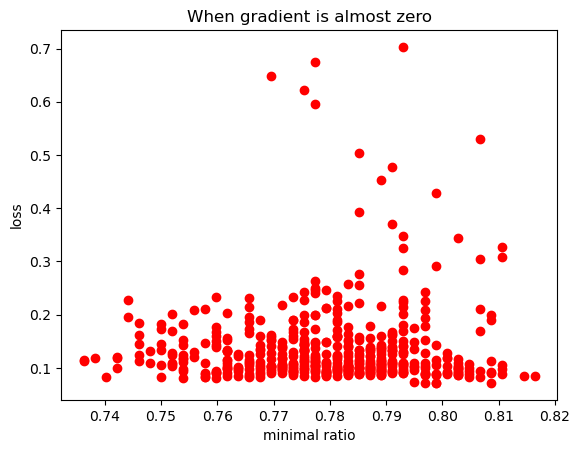

In [21]:
plt.scatter(all_minimal_ratios, all_losses, color='red')
plt.xlabel('minimal ratio')
plt.ylabel('loss')
plt.title('When gradient is almost zero')
plt.show()